# Part 1: Spotify Project



Author: Cristobal Zamorano Astudillo



## Introduction

[Spotify](https://www.spotify.com/) is one the most popular audio streaming platforms on the planet. Just like other tech companies, Sotift has uploaded their API, so that developers can explore their music database to get insights into the Spotify users' listing habits.

For this project, I requested Spotify to give the largest amount of information of the music that I've listened in their platform. The company was only able to give me a year long of history and the access to all my playlists, payments, liked music, and other information related to me as Spotify user. For more information, you can check their website [here](https://support.spotify.com/uk/account_payment_help/privacy/understanding-my-data/)

<b>The Goal of this Project is to use the Spotify data to understand myself as a user.</b>

We will use Machine Learning algorthims to try to predict my pcoming music...


### Loading Dataset & Data Manipulation

In [1]:
# Data Manipulation 
import pandas as pd

# Linear Algebra and Math
import numpy as np

# 2D Visualizations
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

# 3D Visualizations
import plotly.express as px
import plotly.graph_objects as go
import cufflinks as cf
from plotly.offline import iplot
import plotly as py

# Decisiton Tree
import pydotplus
import io
import graphviz
from scipy import misc
import imageio

# from matplotlib.colors import DivergingNorm

%matplotlib inline

In [2]:
# I'm a big fan of  https://fivethirtyeight.com/ and their visualizations :) 
style.use('fivethirtyeight') 
# grid: rgb(240,240,240)
# background: rgb(200,200,200)

# Color pallette
# 
# Spotify Green: #1DB954
# Spotify Black: #191414
# Netflix Red: #E50914
# Spanish Blue: #246EB9
# Amazon Orange: #FF9900
# Maximum Red Purple: #A74482
# Gold Fusion: #84714F


green_black = ['#1DB954', '#191414'] #[like, dislke]
pallette = sns.color_palette(green_black)
sns.set_palette(pallette)
# sns.set_style('white')


In [3]:
my_songs_df = pd.read_csv("./output/final.csv")

In [4]:
my_songs_df.shape

(33739, 25)

In [5]:
my_songs_df.columns

Index(['Unnamed: 0', 'name', 'endTime', 'artistName', 'trackName', 'msPlayed',
       'datetime', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'id', 'uri', 'track_href', 'analysis_url',
       'duration_ms', 'time_signature'],
      dtype='object')

Let's have a first glance of our dataset and see if we have missing values:

In [6]:
# Missing values
def missing_values_func(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
            columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
    
        # Returns
        if mis_val_table_ren_columns.empty:
            return f'Your selected dataframe has  {df.shape[1]} features. There are  {mis_val_table_ren_columns.shape[0]} features that have missing values.'
        else:
            display(mis_val_table_ren_columns.style.background_gradient(cmap='Reds'))
            return f'Your selected dataframe has  {df.shape[1]} features. There are  {mis_val_table_ren_columns.shape[0]} features that have missing values.'
        
missing_values_func(my_songs_df)

'Your selected dataframe has  25 features. There are  0 features that have missing values.'

### Spotify Features

Here is the list of columns that the Spotify API uses as metrics to evaluate their music:


| Key   |      Value Type      |  Value Description |
|----------|:-------------:|------:|
| duration_ms |  int | 	The duration of the track in milliseconds. |
| key|    int   |   	The estimated overall key of the track. Integers map to pitches using standard [Pitch Class notation](https://en.wikipedia.org/wiki/Pitch_class).  E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1. |
| mode| int |    	Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0. |
|time_signature | int | 	An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).|
|acousticness | float | A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. |
|danceability| float | Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. |
| energy | float | Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. |
| instrumentalness | float | Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. |
| liveness | float | Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live. |
| loudness | float | The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db. |
| speechiness | float | 	Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. |
| valence | float | A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). |
| tempo | float | 	The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. |
| id | string | The Spotify ID for the track. |
| uri | string | The Spotify URI for the track. |
| track_href | string | A link to the Web API endpoint providing full details of the track. |
| analysis_url | string | 	An HTTP URL to access the full audio analysis of this track. An access token is required to access this data. |
| type | string | 	The object type: “audio_features” |


*Source: [Spotify's Audio Feature Object](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/)*

### Spotify Data Requests features from Streaming History in the JSON files

| Key   |      Value Type      |  Value Description |
|----------|:-------------:|------:|
| endTime |  string | 	Date and time of when the stream ended in UTC format (Coordinated Universal Time zone).  |
| artistName | string | Name of "creator" for each stream (e.g. the artist name if a music track). |
| trackName | string | Name of items listened to or watched (e.g. title of music track or name of video). |
| msPlayed | int | Stands for how many mili-seconds the track was listened. |

*Source: [Understanding my data](https://support.spotify.com/uk/account_payment_help/privacy/understanding-my-data/)*

#newpage

## Section 1: EDA

### Feature Selection vs Dimensionality Reduction

Feature selection is simply selecting and excluding given features without changing them.

Dimensionality reduction transforms features into a lower dimension.

Examples of Feature Selection:

- Remove features with missing values
- Remove features with low variance
- Remove highly correlated features 
- Remove features that are multiple of each other
- Remove features that are linear combinations of others
- Remove features that consist of only one variable value
- Remove features that are the least importance with respect the others by using recursive methods such as `sklearn.feature_selection import RFE`
- Similar to the previous bullet point, we can use `from sklearn.feature_selection import SelectFromModel` to remove features with values below a set threshold. 

Examples of Dimensionality Reduction:

- PCA (Principal Component Analysis) **We will use this in this project**
- t-SNE (t-Distributed Stochastic Neighbor Embedding)

#### Feature Elimination: Remove features with same values/ multiple of each other

Let's see if some features have the same equivalent respective values but with the different feature names.

- Compare `name` vs `trackName`
- Compare index vs `Unnamed: 0`
- `id`, `uri`, `track_href`, `analysis_url` are all features that their values are website with the same information that we have in this dataset. Each value is unique to each song and artist.

Then proceed to drop one of them.

**Note**: in the case of the index and `Unnamed: 0`, we'll keep the index to be able to manipulate the rest of data with an index.

In [7]:
(my_songs_df['name'] == my_songs_df['trackName']).value_counts()

True    33739
dtype: int64

In [8]:
(my_songs_df['Unnamed: 0'] == my_songs_df.index).value_counts()

True    33739
dtype: int64

In [9]:
my_songs_df.drop(columns = ['Unnamed: 0', 'trackName', 'id', 'uri', 'track_href', 'analysis_url'], inplace = True)

Let's rename some features such as:

- `artistName` to `artist`
- `name` to `song_name`

In [10]:
my_songs_df.rename(columns={"artistName": "artist","name": "song_name"}, inplace=True)
my_songs_df.tail()

song_name           endTime           artist  msPlayed  \
33734              Nadie Como Tú  2020-02-07 14:09         Miranda!      1170   
33735            Suena El Dembow  2020-02-07 14:09     Joey Montana      1350   
33736  Solo Por Ti (feat. Guaco)  2020-02-07 14:09  Nelson Arrrieta       960   
33737             Loco Enamorado  2020-02-07 14:09    Abraham Mateo       970   
33738                 Noche Loca  2020-02-07 14:09           Marama       890   

                  datetime  danceability  energy  key  loudness  mode  \
33734  2020-02-07 14:09:00         0.810   0.723    4    -5.200     0   
33735  2020-02-07 14:09:00         0.690   0.858    0    -4.431     1   
33736  2020-02-07 14:09:00         0.736   0.854    7    -5.438     1   
33737  2020-02-07 14:09:00         0.674   0.645    8    -4.980     1   
33738  2020-02-07 14:09:00         0.847   0.552   11    -7.792     0   

       speechiness  acousticness  instrumentalness  liveness  valence  \
33734       0.1940         0.409               0.0     0.137    0.738   
33735       0.0531         0.189               0.0     0.113    0.755   
33736       0.0426         0.249               0.0     0.240    0.855   
33737       0.0303         0.190               0.0     0.144    0.615   
33738       0.1270         0.442               0.0     0.121    0.582   

         tempo            type  duration_ms  time_signature  
33734   92.993  audio_features       222867               4  
33735   91.883  audio_features       195760               4  
33736  104.985  audio_features       244036               4  
33737  155.961  audio_features       209093               3  
33738   97.984  audio_features       230981               4

#### Feature Selection: `msPlayed` feature engineering 

Let's see how many songs were played in my Streaming History for <b>less than 30 seconds</b>. To accomplish this we will use the `msPlayed` feature provided by the Spotify data request. Then we will proceed to drop the songs that were listened for less than 30000 milliseconds or 30 seconds.

According to [Spotify for Artists](https://artists.spotify.com/) a song is counted as "listened" by a user if the stream has been listened for at least 30 seconds. Let's use this criteria.

*Source: [FAQ on the Stats provided by Spotify for Artists' website](https://artists.spotify.com/faq/stats#how-are-streams-counted)*

In [11]:
print(f'Number of songs played in my Streaming History for less than 30 seconds: ',my_songs_df[my_songs_df['msPlayed'] < 30000].shape[0])

Number of songs played in my Streaming History for less than 30 seconds:  13877


In [12]:
my_songs_df = my_songs_df[my_songs_df['msPlayed'] >= 30000]
my_songs_df.shape[0]

19862

Let's see if some columns are insignificant in terms of value to if are dropable:
- The feature `type` seems to have only one value.

In [13]:
my_songs_df['type'].value_counts()

audio_features    19862
Name: type, dtype: int64

In [14]:
my_songs_df.drop(columns=['type'], inplace=True)

#### Feature Extraction: Time Features

Let's add some various useful features such related to the time given by the provided `datetime` feature:

- Add a `Date` feature that just have the the "Year-Month-Day' portion of `datetime`.
- Add a `Hour` feature that has the hour in 24hr format as an `int`.
- Add a `Month` feature that has the month in 1 to 12 months format as an `int`.
- Add a `Day` feature that has the name of the day as a `String`.
- Add a `Year` feature that has the year which is either 2019 or 2020 as a `int`.
- Add a `Week_of_Year` feature that has the week of their respective year in a format of 1 to 52 as an `int`.
- Add a `Day_of_Year` feature that has the day in a format of 1 to 365 as an `int`.
- Add a `Quarter` feature that has the quarter information in a format of 1 to 4 as an `int`.
- Add a `Season` feature that has the season information in a "Fall, Winter, Summer, Spring" format as a `String` using the week number with respect their respective year.


In [15]:
# my_songs_df["datetime"].replace(inplace=True,to_replace="1899-12-30T00:00:00.000Z",value="00:00")
my_songs_df["Date"] = pd.to_datetime(my_songs_df["datetime"], utc = True)
my_songs_df["Hour"] = pd.to_datetime(my_songs_df['Date'], format='%H:%M' , utc = True).dt.hour
my_songs_df["Month"] = pd.to_datetime(my_songs_df["Date"], utc = True).dt.month 
my_songs_df["Day"] = pd.to_datetime(my_songs_df["Date"], utc = True).dt.weekday_name
my_songs_df["Year"] = pd.to_datetime(my_songs_df["Date"], utc = True).dt.year
my_songs_df["Week_of_Year"] = pd.to_datetime(my_songs_df["Date"], utc = True).dt.weekofyear
my_songs_df["Day_of_Year"] = pd.to_datetime(my_songs_df["Date"], utc = True).dt.dayofyear
my_songs_df["Quarter"] = pd.to_datetime(my_songs_df["Date"], utc = True).dt.quarter

my_songs_df["Date"] = pd.to_datetime(my_songs_df["Date"], utc = True).dt.date

season_dict = lambda x: "Winter" if ((x< 12) | (x >= 51)) else "Spring" if ((x >= 12) & (x < 25)) else "Summer" if ((x >= 25) & (x < 38)) else "Fall"

my_songs_df["Season"] = my_songs_df["Week_of_Year"].map(season_dict)


# Drop datetime
my_songs_df.drop(['datetime'],axis = 1, inplace= True)

The new features are the following:

In [16]:
my_songs_df[['Hour', 'Month', 'Day', 'Year', 'Week_of_Year', 'Day_of_Year', 'Quarter', 'Date', 'Season']].head()

Hour  Month     Day  Year  Week_of_Year  Day_of_Year  Quarter        Date  \
6     14      2  Friday  2020             6           38        1  2020-02-07   
9     14      2  Friday  2020             6           38        1  2020-02-07   
24    14      2  Friday  2020             6           38        1  2020-02-07   
33    14      2  Friday  2020             6           38        1  2020-02-07   
34    14      2  Friday  2020             6           38        1  2020-02-07   

    Season  
6   Winter  
9   Winter  
24  Winter  
33  Winter  
34  Winter

These new features should be useful for this project because I want to see when exactly during the 2019-2020 period I listened to most music and if I can relate in some way to that time.

For a quick view of the new data, let's see in what weather season I listened to most music in Spotify:

In [17]:
my_songs_df['Season'].value_counts()

Fall      5866
Spring    5772
Summer    4501
Winter    3723
Name: Season, dtype: int64

In [18]:
my_songs_df.shape

(19862, 26)

Let's turn the `Season` and `Day` features into numeric value features for Feature Selection and Modeling purposes later on in this project.

In [19]:
day_numeric = lambda x : 1 if x == "Monday" else 2 if x == "Tuesday" else 3 if x == "Wednesday" else 4 if x == "Thursday" else 5 if x == "Friday" else 6 if x == "Saturday" else 7
season_numeric = lambda x : 1 if x == "Winter" else 2 if x == "Spring" else 3 if x == "Summer" else 4
my_songs_df["Season_Numeric"] = my_songs_df["Season"].map(season_numeric)
my_songs_df["Day_Numeric"] = my_songs_df["Day"].map(day_numeric)
my_songs_df.shape

(19862, 28)

In [20]:
missing_values_func(my_songs_df)

'Your selected dataframe has  28 features. There are  0 features that have missing values.'

### Liked Songs 

Let's create a new column called `liked` of 1s and 0s. 
- The <b>1s</b> are songs that I've liked (For those of you that are familiar with Spotify - the songs that have a green heart and are automatically saved in the Liked Songs playlist.)
- The <b>0s</b> are songs that I've listened to but did not saved in my Liked Songs playlists

This column will compare the name of the songs of the `my_songs_df` DataFrame against the name of the songs of the `liked_songs_df`.

Let's clean the `liked_songs_df` dataset by renaming the columns. The `my_liked_songs.csv` was obtained from the `./MyData/YouLibrary.json`. As mentioned before all the files in the `MyData` folder are from the Spotify personal Data request. 

In order to turned the JSON file into a CSV file, I used a website called [ConvertCSV](https://www.convertcsv.com/) where you can convert various type of files into CSV format. I only had to copy and paste the JSON file into the web application. The website is free of monetary charge and you can check out the JSON to CSV converter [here](https://www.convertcsv.com/json-to-csv.htm)

In [21]:
liked_songs_df = pd.read_csv('datasets/my_liked_songs.csv')
liked_songs_df.rename(columns={"tracks/artist": "artist", "tracks/album": "album", "tracks/track": "song_name"}, inplace=True)
liked_songs_df.tail()

artist                                      album  \
1801  Carly Rae Jepsen                           Run Away With Me   
1802      Alex Sparrow                 She's Crazy but She's Mine   
1803      Megan Davies  See You Again, Love Me Like You Do, Sugar   
1804            AmaLee                               Nostalgia IV   
1805            AmaLee            Glassy Sky (From "Tokyo Ghoul")   

                                              song_name  
1801                                   Run Away With Me  
1802                         She's Crazy but She's Mine  
1803  See You Again, Love Me Like You Do, Sugar - Ac...  
1804                              Rolling Star (Bleach)  
1805                    Glassy Sky (From "Tokyo Ghoul")

In [22]:
missing_values_func(liked_songs_df)

'Your selected dataframe has  3 features. There are  0 features that have missing values.'

In [23]:
my_songs_df["exists"] = my_songs_df["song_name"].isin(liked_songs_df["song_name"])

In [24]:
my_songs_df["exists"].value_counts()

True     13397
False     6465
Name: exists, dtype: int64

In [25]:
my_songs_df[my_songs_df['exists'] == False].tail()

song_name           endTime          artist  \
33597                    Schumann Resonance  2020-02-06 23:16  Binaural Beats   
33600     Smile Bomb (From "Yu Yu Hakusho")  2020-02-07 01:16          AmaLee   
33606                        Physical vigor  2020-02-07 04:37  Binaural Beats   
33670                            Buscándote  2020-02-07 13:35      Mike Bahía   
33720  Goya no Machiawase (From "Noragami")  2020-02-07 14:02          AmaLee   

       msPlayed  danceability  energy  key  loudness  mode  speechiness  ...  \
33597   1231551         0.434  0.0471    2   -31.747     0       0.0457  ...   
33600     73221         0.545  0.9190    5    -3.636     0       0.1370  ...   
33606   2067736         0.000  0.0000    0   -40.634     0       0.0000  ...   
33670    101310         0.687  0.6590    9   -10.012     1       0.0994  ...   
33720    130210         0.263  0.9830   11    -2.114     0       0.3310  ...   

       Month       Day  Year  Week_of_Year  Day_of_Year  Quarter  Season  \
33597      2  Thursday  2020             6           37        1  Winter   
33600      2    Friday  2020             6           38        1  Winter   
33606      2    Friday  2020             6           38        1  Winter   
33670      2    Friday  2020             6           38        1  Winter   
33720      2    Friday  2020             6           38        1  Winter   

      Season_Numeric  Day_Numeric  exists  
33597              1            4   False  
33600              1            5   False  
33606              1            5   False  
33670              1            5   False  
33720              1            5   False  

[5 rows x 29 columns]

Any of these songs <b>are certainly not</b> in my Liked Songs playlists.

Now, let's create the `liked` feature using a [lambda function](https://www.w3schools.com/python/python_lambda.asp) on my entire Streaming History Data Frame.

In [26]:
like_func = lambda x: 1 if x==True else 0
my_songs_df['liked'] = my_songs_df['exists'].map(like_func)
my_songs_df['liked'].value_counts()

1    13397
0     6465
Name: liked, dtype: int64

### Favorite Songs from the Streaming History

Let's explore what were my most listened songs during 2019-2020. For this we will be using the entire dataset of my streaming history. 

In order to see what is considered a favorite song or not, we will see at the **count** of a particular song with his or her artist or band **with respect to the rest of song**. So far, we don't know what count is considered enough to be favorite song. The let's do the following:

- Use `.groupby` on the `artist` and `song_name` features to visualize the frequency of the songs. With this we want to know how the frequency behaves and see if we can pick an arbitrary number from the visualization.
- Once we know the number we will exclude all other songs that are **less than that count**.
- We will create a new DataFrame with following features: `artist`, `song_name`, and `count`, where the the values of `count` must be above a certain number that we know proceed to discover.

In [27]:
my_songs_df.groupby(['artist','song_name']).size().to_frame('count').reset_index()[['song_name', 'count']].head()

song_name  count
0           Algo más      1
1      Hasta la luna      2
2    Vuelve Otra Vez      9
3          Sleepwell      1
4  We Think Too Much      1

In [28]:
# Find number of occurences of each song, and keep songs with 22.888 or more listnes
fav_songs_df = my_songs_df.groupby(['artist','song_name']).size().to_frame('count').reset_index()
fav_songs_df = fav_songs_df.sort_values(by=['count'], ascending = False).reset_index(drop=True)
fav_songs_df.rename(columns={"count": "Counts_per_Song"}, inplace=True)
fav_songs_df['Counts_per_Song'].value_counts()

1      2631
2       637
3       249
4       144
5        65
       ... 
77        1
73        1
57        1
61        1
121       1
Name: Counts_per_Song, Length: 86, dtype: int64

In [29]:
# my_songs_df.groupby(['artist','song_name']).size().to_frame('count').reset_index['count'].transform('count')

In [30]:

df = my_songs_df.groupby(['artist','song_name']).size().to_frame('count').reset_index()
fig = px.histogram(df, x="count",
                   title='Histogram of counted music',
                   labels={'count':'Number_of_Songs' }, # can specify one label per df column
                   opacity=1,
                   log_y=False, # represent bars with log scale
                   color_discrete_sequence=['#1DB954'])
fig.update_layout(
    title_text='Sampled Results', # title of plot
#     xaxis_title_text='Value', # xaxis label
    yaxis_title_text='Times Listened', # yaxis label
    bargap=0.5, # gap between bars of adjacent location coordinates
    xaxis=dict(range=[0,40]),
    yaxis=dict(range=[0,1000]),
    bargroupgap=.5, # gap between bars of the same location coordinates
    plot_bgcolor = "rgb(240, 240, 240)", 
    paper_bgcolor = "rgb(240, 240, 240)",
    hovermode='x unified',
    font=dict(
        size=12,
        color='#444'
    )
)

fig.update_xaxes(
    showline=False,
    linewidth=0.5,
    linecolor='black',
    mirror=False,
    showgrid=True,
    gridwidth=1,
    gridcolor='rgb(200, 200, 200)',
    zerolinecolor='rgb(240, 240, 240)',
    zerolinewidth=1, 
    spikesnap = 'hovered data',
    spikecolor = '#FF9900',
    spikethickness = 3,
    showspikes = False
)
fig.update_yaxes(
    showline=False,
    linewidth=0.5,
    linecolor='black',
    mirror=False,
    showgrid=True,
    gridwidth=1,
    gridcolor='rgb(200, 200, 200)',
    zerolinecolor='black',
    zerolinewidth=1, 
    spikesnap = 'hovered data',
    showspikes = False
)
fig.show()

In [31]:
fav_songs_df[fav_songs_df['song_name'] == 'Call of Silence']

artist        song_name  Counts_per_Song
677  Hiroyuki Sawano  Call of Silence                4

In [32]:
# my_songs_df['counts_per_song'] = fav_songs_df['Counts_per_Song']
# my_songs_df[['song_name','counts_per_song']]

In [89]:
missing_values_func(my_songs_df)

'Your selected dataframe has  30 features. There are  0 features that have missing values.'

In [90]:
my_songs_df.to_csv('./output/project_data/my_songs_clean.csv')

\pagebreak

## Section 2: Visualizations

Now that we have donde some Feature Engineering with just eliminating and adding new features let's visualize them.


### Liked vs No-Liked music using Spotify's metrics

Let's see some distributions of the Streaming History using the Liked music vs the Non-Liked music.

For this goal, we will use [Histograms](https://en.wikipedia.org/wiki/Histogram) to show the numerical distribution of the Spotify metric features.

- We will prepare the data by selecting the liked songs vs the non-liked songs
- The choose the metric feature of interested
- Do the same for all the metrics by creating `subplots`

In [33]:
pos_tempo = my_songs_df[my_songs_df['liked'] == 1]['tempo']
neg_tempo = my_songs_df[my_songs_df['liked'] == 0]['tempo']

pos_dance = my_songs_df[my_songs_df['liked'] == 1]['danceability']
neg_dance = my_songs_df[my_songs_df['liked'] == 0]['danceability']

pos_duration = my_songs_df[my_songs_df['liked'] == 1]['duration_ms']
neg_duration = my_songs_df[my_songs_df['liked'] == 0]['duration_ms']

pos_loudness = my_songs_df[my_songs_df['liked'] == 1]['loudness']
neg_loudness = my_songs_df[my_songs_df['liked'] == 0]['loudness']

pos_speechiness = my_songs_df[my_songs_df['liked'] == 1]['speechiness']
neg_speechiness = my_songs_df[my_songs_df['liked'] == 0]['speechiness']

pos_valence = my_songs_df[my_songs_df['liked'] == 1]['valence']
neg_valence = my_songs_df[my_songs_df['liked'] == 0]['valence']

pos_energy = my_songs_df[my_songs_df['liked'] == 1]['energy']
neg_energy = my_songs_df[my_songs_df['liked'] == 0]['energy']

pos_acousticness = my_songs_df[my_songs_df['liked'] == 1]['acousticness']
neg_acousticness = my_songs_df[my_songs_df['liked'] == 0]['acousticness']

pos_key = my_songs_df[my_songs_df['liked'] == 1]['key']
neg_key = my_songs_df[my_songs_df['liked'] == 0]['key']

pos_instrumentalness = my_songs_df[my_songs_df['liked'] == 1]['instrumentalness']
neg_instrumentalness = my_songs_df[my_songs_df['liked'] == 0]['instrumentalness']

pos_liveness = my_songs_df[my_songs_df['liked'] == 1]['liveness']
neg_liveness = my_songs_df[my_songs_df['liked'] == 0]['liveness']

pos_timesig = my_songs_df[my_songs_df['liked'] == 1]['time_signature']
neg_timesig = my_songs_df[my_songs_df['liked'] == 0]['time_signature']

pos_mode = my_songs_df[my_songs_df['liked'] == 1]['mode']
neg_mode = my_songs_df[my_songs_df['liked'] == 0]['mode']

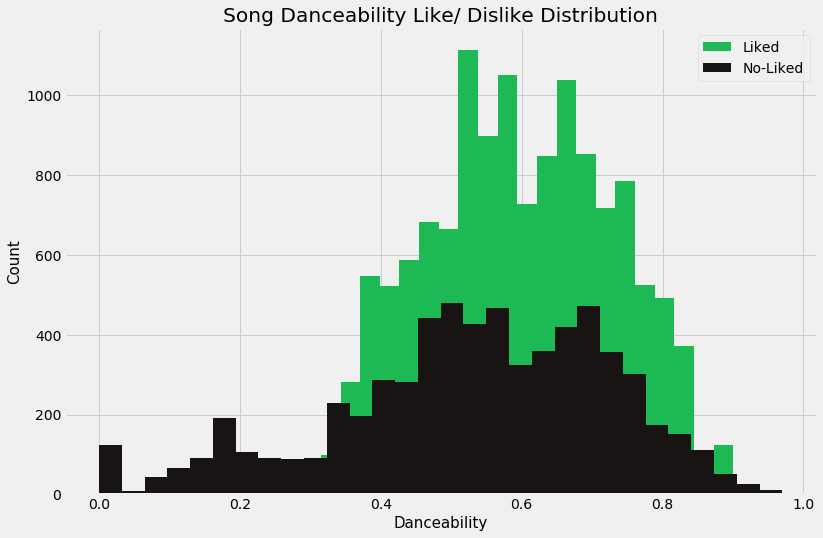

In [34]:
fig = plt.figure(figsize =(12, 8))
plt.xlabel('Danceability',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.title("Song Danceability Like/ Dislike Distribution")
pos_dance.hist(alpha = 1, bins = 30, label = 'Liked')
neg_dance.hist(alpha = 1, bins = 30, label = 'No-Liked')
plt.savefig("./output/images/spotify_distribution.png")
plt.legend(loc = 'upper right')
plt.savefig("./output/images/spotify_distribution.png");

In [35]:
import warnings
warnings.filterwarnings(action='ignore')

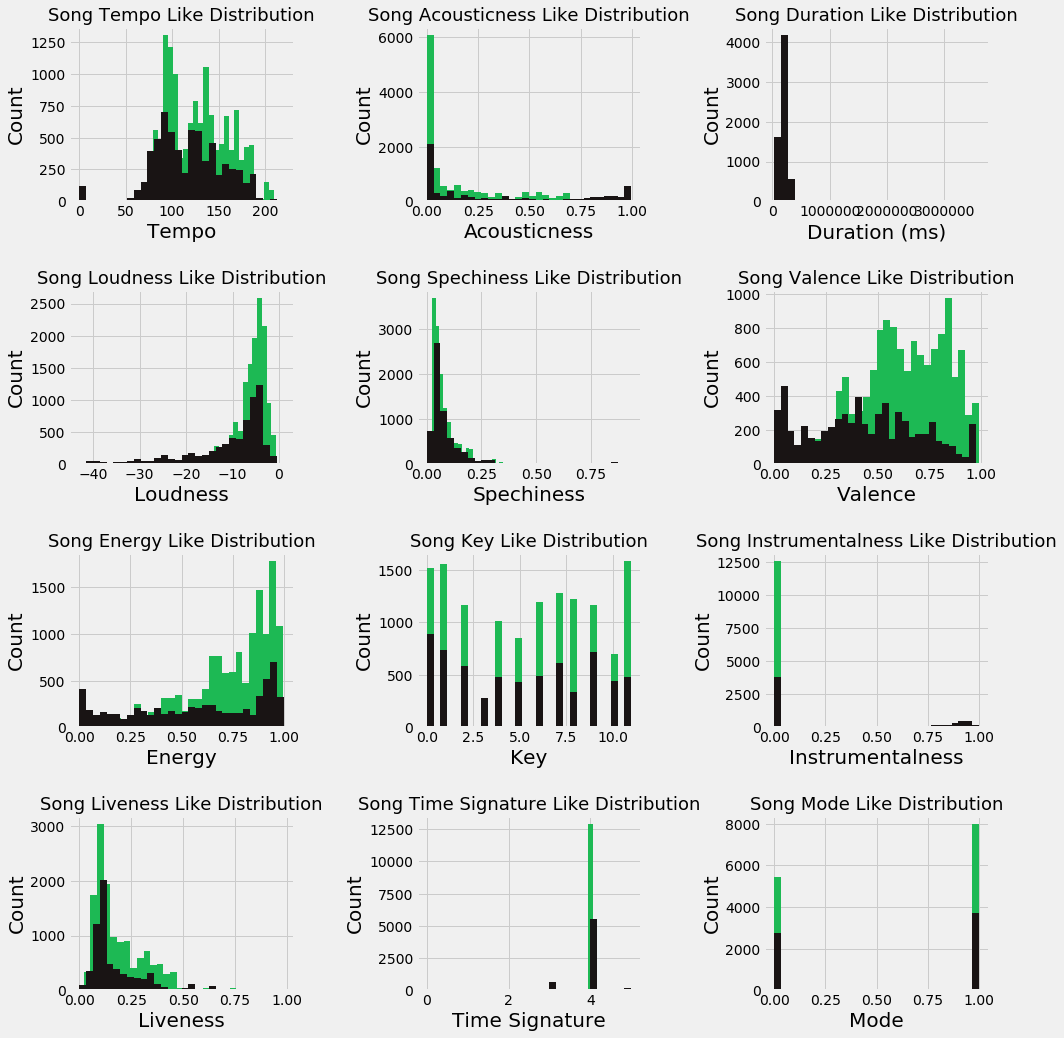

In [36]:
fig2 = plt.figure(figsize=(15,15))


# Tempo
ax3 = fig2.add_subplot(4,3,1)
ax3.set_xlabel('Tempo', fontsize=20)
ax3.set_ylabel('Count', fontsize=20)
ax3.set_title('Song Tempo Like Distribution', fontsize=18)
pos_tempo.hist(alpha = 1, bins = 30)
ax4 = fig2.add_subplot(4,3,1)
neg_tempo.hist(alpha = 1, bins = 30)

# Acousticness
ax5 = fig2.add_subplot(4,3,2)
ax5.set_xlabel('Acousticness', fontsize=20)
ax5.set_ylabel('Count', fontsize=20)
ax5.set_title('Song Acousticness Like Distribution', fontsize=18)
pos_acousticness.hist(alpha = 1, bins = 30)
ax6 = fig2.add_subplot(4,3,2)
neg_acousticness.hist(alpha = 1, bins = 30)

# Duration
ax7 = fig2.add_subplot(4,3,3)
ax7.set_xlabel('Duration (ms)', fontsize=20)
ax7.set_ylabel('Count', fontsize=20)
ax7.set_title('Song Duration Like Distribution', fontsize=18)
pos_duration.hist(alpha = 1, bins = 30)
ax8 = fig2.add_subplot(4,3,3)
neg_duration.hist(alpha = 1, bins = 30)

# Loudness
ax9 = fig2.add_subplot(4,3,4)
ax9.set_xlabel('Loudness', fontsize=20)
ax9.set_ylabel('Count', fontsize=20)
ax9.set_title('Song Loudness Like Distribution', fontsize=18)
pos_loudness.hist(alpha = 1, bins = 30)
ax10 = fig2.add_subplot(4,3,4)
neg_loudness.hist(alpha = 1, bins = 30)

# Speechiness
ax11 = fig2.add_subplot(4,3,5)
ax11.set_xlabel('Spechiness', fontsize=20)
ax11.set_ylabel('Count', fontsize=20)
ax11.set_title('Song Spechiness Like Distribution', fontsize=18)
pos_speechiness.hist(alpha = 1, bins = 30)
ax12 = fig2.add_subplot(4,3,5)
neg_speechiness.hist(alpha = 1, bins = 30)

# Valence
ax13 = fig2.add_subplot(4,3,6)
ax13.set_xlabel('Valence', fontsize=20)
ax13.set_ylabel('Count', fontsize=20)
ax13.set_title('Song Valence Like Distribution', fontsize=18)
pos_valence.hist(alpha = 1, bins = 30)
ax14 = fig2.add_subplot(4,3,6)
neg_valence.hist(alpha = 1, bins = 30)

# Energy
ax15 = fig2.add_subplot(4,3,7)
ax15.set_xlabel('Energy', fontsize=20)
ax15.set_ylabel('Count', fontsize=20)
ax15.set_title('Song Energy Like Distribution', fontsize=18)
pos_energy.hist(alpha = 1, bins = 30)
ax16 = fig2.add_subplot(4,3,7)
neg_energy.hist(alpha = 1, bins = 30)


# Key
ax17 = fig2.add_subplot(4,3,8)
ax17.set_xlabel('Key', fontsize=20)
ax17.set_ylabel('Count', fontsize=20)
ax17.set_title('Song Key Like Distribution', fontsize=18)
pos_key.hist(alpha = 1, bins = 30)
ax18 = fig2.add_subplot(4,3,8)
neg_key.hist(alpha = 1, bins = 30)

# Instrumentalness
ax19 = fig2.add_subplot(4,3,9)
ax19.set_xlabel('Instrumentalness', fontsize=20)
ax19.set_ylabel('Count', fontsize=20)
ax19.set_title('Song Instrumentalness Like Distribution', fontsize=18)
pos_instrumentalness.hist(alpha = 1, bins = 30)
ax20 = fig2.add_subplot(4,3,9)
neg_instrumentalness.hist(alpha = 1, bins = 30);

# Liveness
ax21 = fig2.add_subplot(4,3,10)
ax21.set_xlabel('Liveness', fontsize=20)
ax21.set_ylabel('Count', fontsize=20)
ax21.set_title('Song Liveness Like Distribution', fontsize=18)
pos_liveness.hist(alpha = 1, bins = 30)
ax22 = fig2.add_subplot(4,3,10)
neg_liveness.hist(alpha = 1, bins = 30)

# Time Signature
ax23 = fig2.add_subplot(4,3,11)
ax23.set_xlabel('Time Signature', fontsize=20)
ax23.set_ylabel('Count', fontsize=20)
ax23.set_title('Song Time Signature Like Distribution', fontsize=18)
pos_timesig.hist(alpha = 1, bins = 30)
ax24 = fig2.add_subplot(4,3,11)
neg_timesig.hist(alpha = 1, bins = 30)

# Mode
ax25 = fig2.add_subplot(4,3,12)
ax25.set_xlabel('Mode', fontsize=20)
ax25.set_ylabel('Count', fontsize=20)
ax25.set_title('Song Mode Like Distribution', fontsize=18)
pos_mode.hist(alpha = 1, bins = 30)
ax26 = fig2.add_subplot(4,3,12)
neg_mode.hist(alpha = 1, bins = 30)

plt.savefig("./output/images/spotify_distribution_all_features.png")
plt.tight_layout(pad=2);


### Matrix Heatmaps

Let's use [Matrix Heatmaps](https://en.wikipedia.org/wiki/Heat_map) to visualize the magnitude of the number of music listened in terms of time:

#### Months v/s Days

In [37]:
#Determine the number of accidents for each day of the week by month (combine years 2015-2018)
def RTAs_by_month(df, month):
    month_list = []
    mon, tues, wed, thurs, fri, sat, sun = 0,0,0,0,0,0,0
    
    for idx, row in df.iterrows():
        if row["Month"] == month and row["Day"] == "Monday": mon +=1
        elif row["Month"] == month and row["Day"] == "Tuesday": tues +=1
        elif row["Month"] == month and row["Day"] == "Wednesday": wed +=1
        elif row["Month"] == month and row["Day"] == "Thursday": thurs +=1
        elif row["Month"] == month and row["Day"] == "Friday": fri +=1
        elif row["Month"] == month and row["Day"] == "Saturday": sat +=1
        elif row["Month"] == month and row["Day"] == "Sunday": sun +=1
        else: a=0 

    month_list.append(mon)
    month_list.append(tues)
    month_list.append(wed)
    month_list.append(thurs)
    month_list.append(fri)
    month_list.append(sat)
    month_list.append(sun)
        
    return(month_list)

In [38]:
#Extract RTA data for each day by month
january = RTAs_by_month(my_songs_df, 1)
february = RTAs_by_month(my_songs_df, 2)
march = RTAs_by_month(my_songs_df, 3)
april = RTAs_by_month(my_songs_df, 4)
may = RTAs_by_month(my_songs_df, 5)
june = RTAs_by_month(my_songs_df, 6)
july = RTAs_by_month(my_songs_df, 7)
august = RTAs_by_month(my_songs_df, 8)
september = RTAs_by_month(my_songs_df, 9)
october = RTAs_by_month(my_songs_df, 10)
november = RTAs_by_month(my_songs_df, 11)
december = RTAs_by_month(my_songs_df, 12)

In [39]:
#Create matrix for the heatmap
colmns_1 = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
rows_1 = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
data_1 = np.array([january, february, march, april, may, june, july, august, september, october, november, december])
# heatmap_months_days_df = pd.DataFrame(data=data_1, index=rows_1, columns=colmns_1)
# print(f'Min values: \n', heatmap_months_days_df.min().sort_values(),'\n')
# print(f'Max values: \n', heatmap_months_days_df.max().sort_values())

In [40]:
fig = go.Figure(
    data=go.Heatmap(
        z=data_1,
        x=colmns_1,
        y=rows_1,
        colorscale='YlGn'))
fig.update_layout(
    title='Count of Music Listened in Spotify - Months vs Days - 2019 to 2020',
    plot_bgcolor = 'rgb(240, 240, 240)', 
    paper_bgcolor = 'rgb(240, 240, 240)'
)
fig.show()

In [41]:
# plt.figure(figsize=(15,15))
# # divnorm = DivergingNorm(vmin=43, vcenter=237, vmax=476)
# matrix_1 = sns.heatmap(heatmap_months_days_df,
#                  annot=True,
#                  fmt="d",
#                  cmap='YlGn' ,
#                  annot_kws={"size": 18},
# #                  norm = divnorm,
#                  cbar_kws={"orientation": "horizontal"} ,
#                  xticklabels=True,
#                  yticklabels=True,
#                    linecolor='#dcdcdc',
#                  linewidths=1,
#                  robust = True)
# # _, ylabels = plt.yticks()
# # ax.set_yticklabels(ax.get_yticks(), size=20)
# matrix_1.set_yticklabels(matrix_1.get_ymajorticklabels(), size=20)
# matrix_1.set_xticklabels(matrix_1.get_xmajorticklabels(), fontsize = 20)
# # set the x-labels with
# # _, xlabels = plt.xticks()
# # ax.set_xticklabels(xlabels, size=20)
# plt.title("Count of Songs Listened Month vs Day, Jun 2019- Jun 2020", fontsize = 20)
# matrix_1.set_ylim(-0.5,len(data_1)+0.5)
# plt.yticks(rotation = 0)
# plt.xticks(rotation = 0)

# plt.show();

#### Season v/s Days

In [42]:
#Function to determine number of accidents for per Season of year (2015-2018)

def RTAs_by_season(df, season):
    season_list = []
    mon, tues, wed, thurs, fri, sat, sun = 0,0,0,0,0,0,0
    
    for idx, row in df.iterrows():
        if row["Season"] == season and row["Day"] == "Monday": mon +=1
        elif row["Season"] == season and row["Day"] == "Tuesday": tues +=1
        elif row["Season"] == season and row["Day"] == "Wednesday": wed +=1
        elif row["Season"] == season and row["Day"] == "Thursday": thurs +=1
        elif row["Season"] == season and row["Day"] == "Friday": fri +=1
        elif row["Season"] == season and row["Day"] == "Saturday": sat +=1
        elif row["Season"] == season and row["Day"] == "Sunday": sun +=1
        else: a=0 

    season_list.append(mon)
    season_list.append(tues)
    season_list.append(wed)
    season_list.append(thurs)
    season_list.append(fri)
    season_list.append(sat)
    season_list.append(sun)
        
    return(season_list)

In [43]:
fall = RTAs_by_season(my_songs_df, "Fall")
summer = RTAs_by_season(my_songs_df, "Summer")
winter = RTAs_by_season(my_songs_df, "Winter")
spring = RTAs_by_season(my_songs_df, "Spring")

In [44]:
#Create matrix for the heatmap
colmns_2 = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
rows_2 = ["Summer", "Fall", "Winter", "Spring"]
data_2 = np.array([summer, fall, winter, spring])
# heatmap_season_days_df = pd.DataFrame(data=data_2, index=rows_2, columns=colmns_2)
# print(f'Min values: \n', heatmap_season_days_df.min().sort_values(),'\n')
# print(f'Max values: \n', heatmap_season_days_df.max().sort_values())

In [45]:
fig = go.Figure(
    data=go.Heatmap(
        z=data_2,
        x=colmns_2,
        y=rows_2,
        colorscale='YlGn'))
fig.update_layout(
    title='Count of Music Listened in Spotify - Season vs Days - 2019 to 2020',
    plot_bgcolor = 'rgb(240, 240, 240)', 
    paper_bgcolor = 'rgb(240, 240, 240)'
)
fig.show()

In [46]:
# plt.figure(figsize=(15,15))

# # # rdgn = sns.diverging_palette(h_neg=50, h_pos=134.2, s=96.0, l=66.2, sep=3, as_cmap=True, center='dark')
# # temp = sns.dark_palette(as_cmap=True, color = '#1DB954')
# # divnorm = DivergingNorm(vmin=394, vcenter=499, vmax=1004)
# matrix_2 = sns.heatmap(
#     heatmap_season_days_df,
#     annot=True,
#     annot_kws={"size": 20},
#     fmt="d",
#     cmap='YlGn' ,
# #     norm = divnorm,
#     cbar_kws={"orientation": "horizontal"} ,
#     xticklabels=True,
#     yticklabels=True,
#     linewidths=1,
#     linecolor='#dcdcdc',
#     square=True,
#     robust = True)
# # set the x-labels with
# matrix_2.set_yticklabels(matrix_2.get_ymajorticklabels(), size=20)
# matrix_2.set_xticklabels(matrix_2.get_xmajorticklabels(), fontsize = 20)
# plt.title("Count of Music listened by Season, Jun 2019 - Jun 2020", fontsize = 20)
# matrix_2.set_ylim(-0.5,len(data_2)+0.5)
# plt.yticks(rotation = 0)

# plt.show();

#newpage

## Section 3: Dimensionality Reduction

Throughout this project we have done Exploratory Data Analysis (EDA) on various features and other datasets from Spotify in order to have a better sense of the streaming history of the songs. However, we still don't know if any of the provided features from Spotify or new features are a meaningful basis to re-express the streaming history dataset. The goal of this section is to filter the noise and reveal hidden structure of the dataset, because we rather handle a dataset with few features: it will be far easier and faster to train. On the other hand, we do not want to lose important information while getting rid of some features.

Let's use [Principal Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis),  simple yet popular and useful linear transformation technique that is used in numerous applications, such as stock market predictions, the analysis of gene expression data, and many more,  to have a better sense of our data features.

##### What is PCA?

PCA simplifies the complexity in high-dimensional data while retaining trends and patterns. We transform the dataset, $\mathbf{X}$, of dimension $n$ into a $k$ dimensional subspace or fewe dimensions. From now on we will always assume that $k \leq k$ for reading purposes. The fewer dimensions act as summaries of features.

###### Why using PCA with the Spotify data?

Given the mostly quantitative data that Spotify uses for their software are quantitative, we have extracted the time into numerical quantities that are easy to manipulate, and we have target feature `liked` of liked songs as 1s and 0s, then PCA should give us a better understand how valuable are those numbers with respect to the dataset.


##### Why PCA?

Often we work with hundreds or larger dataset features or sometimes we don't understand very well what the feature values really mean. For example, for this project we don't really know what relavance of having `acousticness` over `energy`, are these related or not? So, we want to find ways to summarize those features into a smaller $k$ number of features. A natural question is "what is the size of $k$ that represents the data 'well'?"

Principal components are new features that are constructed as linear combinations of the initial features. These combinations are done in such a way that these new variables are uncorrelated and most of the information within the initial features is stored into the first components. So, the idea is that $k$-dimensional data give you $k$ principal components, but PCA tries to put maximum possible information in the first ones, so that, if you want to reduce your dataset’s dimensionality, you can focus your analysis on the first few components without suffering a great penalty in terms of information loss. We will see that PCA is not just a "black box", and we are going to unravel its internals steps.

##### What's the Goal of PCA?

Find the best summary of the data using a limited number of Principal Components. We wanto maximize the variance and not to find clusters.

##### What do you mean by maximizing the informarion into a $k$-dimensional subspace?

By maximizing I mean that we use the power of Linearity by creating a sequences of projections of the original data that are uncorrolated with previous PCs and ordered by variance.

For example, projection onto PC1 is uncorrelated with projection onto PC2, and we can thing of PCs as geometrically orthogonal (perpendicular). 

No correlation is a requirement for PCA to happen. We will use a Covariance Matrix to make sure that there are no major correlation clusters among features.

The smaller $k$-dimensional subspace is the result of a sequence of maximizing the correlation between the data projections and the original data $\mathbf{X}$.

##### How's PCA or the dimensionalty reduction is even possible? Is this some sort of magic?

The idea of PCA mainly comes from elementary functions that we learn in secondary or elementary school that can be extended to a set of Linear Transformations.

Consider some mathematical function $f: \mathbf{R}^a \to \mathbf{R}^b$, and given $\exists f^{-1}$, then we can take the inverse of $f$ and create a Linear Map such that $f^{-1}: \mathbf{R}^b \to \mathbf{R}^a$. If we consider $f: \mathbf{R}^a \to \mathbf{R}^b$ as our original dataset we can actually go back forward with its inverse $f^{-1}$ by making the function $f$ a linear operator. Specially if we can make our $f$ an isomorphic linear operator that we can now call $T$. We can make the linear operator $T$ to work in $T \in \mathcal{L}\left(\mathbf{R}\right)$ as $\mathbf{R}$ acts as a Vector Space. We will our original matrix dataset into a square matrix so $T \in \mathcal{L}\left(\mathbf{R}\right)$ becomes an isomorphsim which will be very important to access the Eigenspace of our original data.

Later, we will compute eigenvectors (the principal components values) of $\mathbf{X}$ and collect them in a projection matrix. Each of those eigenvectors is associated with an eigenvalue which can be interpreted as the "length" or "magnitude" of the corresponding eigenvector. If some eigenvalues have a significantly larger magnitude than others that the reduction of the dataset via PCA onto a smaller dimensional subspace by dropping the "less informative" eigenpairs is reasonable. This Eigenvectors will finally tell us how we well we can classify our dataset using a Machine Learning model or not.

##### How can I learn more about PCA? Is there are different ways to build PCA?

You can take a look at this useful PCA tutorial reading [here](https://arxiv.org/pdf/1404.1100.pdf). I personally found this paper very useful to understand more in depth PCA and how this Machine Learning algorithm is constructed on top of other academic disciplines that act as the building blocks of PCA. It is expected that the reader has a solid knowledge and understanding of many Linear Algebra topics. If you need to refresh or want to learn about Linear Algebra, I personally recomend this book called [*Linear Algebra Done Right by Sheldon Axler*](http://linear.axler.net/) because of the consice examples, colorful format, and the way is organized is slightly different than other Linear Algebra books (it introduce the concept of [Derivative](https://en.wikipedia.org/wiki/Derivative) (a core concept in Linear Algebra) towards the end instead of the begining like most books), which I found it intersting. Also, I used this book when I took [Math 110: Linear Algebra](https://math.berkeley.edu/~ribet/110/), an upper division Linear Algebra course, with Professor [Ken Ribet](https://en.wikipedia.org/wiki/Ken_Ribet), a very well known mathematician who teaches at UC Berkeley. 

The PCA paper was obtained in my [Data 100: Principles and Techniques of Data Science](http://www.ds100.org/), a course that I greatly enjoyed and it was taught by another talented UC Berkeley Professors [Deborah Nolan](https://www.stat.berkeley.edu/~nolan/) and [Josh Hug](https://www2.eecs.berkeley.edu/Faculty/Homepages/joshhug.html), as one the optional readings in the course.

It is also important to clarify that there are different ways to do PCA. For example, you can use [Singular Value Decomposition (SVD)](https://en.wikipedia.org/wiki/Singular_value_decomposition) to decompose the original dataset using transformation matrices to create a new $\mathbf{X}$ such that $\mathbf{X} = \mathbf{U}\mathbf{\Sigma}\mathbf{V}^T$, where $\mathbf{\Sigma}$ is a diagonal matrix with singular values. In the SVD algorithm we are particularly interested in the $\mathbf{U}\mathbf{\Sigma}$ matrix because its columns are the Principal Components of $\mathbf{X}$. [Here](https://docs.google.com/presentation/d/1cNJHYds1Q9cyMFRpPejttZ1QNJmAyGM-IMyR8gd8Cxg/edit#slide=id.g646fa6b3e3_0_1059) are some Google slides explaining Dimensionality Reduction and PCA using SVD by Professor [Josh Hug](https://www2.eecs.berkeley.edu/Faculty/Homepages/joshhug.html). 

For this project I want to approach PCA in a different way. Using the core basis of the PCA theory, I want to explore how other subjects such as Linear Algebra, Estimation Theory, and Statistics can actually interwined together to approach this  fantastic Machine Learning algorithm.

#### Steps for PCA in this project:

1. Standardize the data.
2. Eigendecomposition - Computing the Eigenvectors and Eigenvalues from the covariance matrix or correlation matrix
3. Sort eigenvalues in descending order and choose the  eigenvectors that correspond to the $k$ largest eigenvalues where $k$ is the number of dimensions of the new feature subspace $k \leq n$.
4. Construct the projection matrix $\mathbf{W}$ from the selected $k$ eigenvectors.
5. Transform the original dataset $\mathbf{X}$ via $\mathbf{W}$ to obtain a $m$-dimensional feature subspace $\mathbf{Y}$. Construct $\mathbf{Y} = \mathbf{X} \mathbf{W}$


In [47]:
my_songs_df.columns

Index(['song_name', 'endTime', 'artist', 'msPlayed', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature', 'Date', 'Hour', 'Month', 'Day', 'Year',
       'Week_of_Year', 'Day_of_Year', 'Quarter', 'Season', 'Season_Numeric',
       'Day_Numeric', 'exists', 'liked'],
      dtype='object')

In order to use PCA we need to use **only numerical features**. Thus, we will exclude the following features: `song_name`, `endTime`, `artist`, `datetime`, `exists`, `Day`, `Season`.

**Note** that for all of these features we have extracted important information as numerical format already. Except for `song_name` and `artist`.

In [48]:
# Exclude Date because I don't see the relevance on using a specific day since we cannot time travel...
# Exclude Year
metrics = my_songs_df[['msPlayed',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','duration_ms',
       'time_signature',
                       'Hour', 'Month', 'Week_of_Year', 'Day_of_Year', 'Quarter',  
                       'Season_Numeric', 'Day_Numeric']].reset_index(drop=True)
metrics.tail()

msPlayed  danceability  energy  key  loudness  mode  speechiness  \
19857    144960         0.504   0.380    6   -11.826     0       0.0370   
19858    130210         0.263   0.983   11    -2.114     0       0.3310   
19859    197131         0.331   0.984    8    -2.773     1       0.1480   
19860     46650         0.695   0.875    6    -6.397     1       0.0875   
19861    122800         0.783   0.651    9    -6.757     0       0.0338   

       acousticness  instrumentalness  liveness  ...    tempo  duration_ms  \
19857       0.64200          0.857000    0.0697  ...  123.911       178213   
19858       0.00105          0.000002    0.3840  ...   93.669       161746   
19859       0.03750          0.000001    0.3710  ...  172.100       227040   
19860       0.12900          0.000000    0.0672  ...  166.058       205387   
19861       0.50300          0.000013    0.1210  ...  101.015       332653   

       time_signature  Hour  Month  Week_of_Year  Day_of_Year  Quarter  \
19857               4    14      2             6           38        1   
19858               4    14      2             6           38        1   
19859               4    14      2             6           38        1   
19860               4    14      2             6           38        1   
19861               4    14      2             6           38        1   

       Season_Numeric  Day_Numeric  
19857               1            5  
19858               1            5  
19859               1            5  
19860               1            5  
19861               1            5  

[5 rows x 21 columns]

In [49]:
# metrics.drop(columns=[ 'Day','Season'], inplace = True)

In [50]:
metrics.columns

Index(['msPlayed', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'Hour', 'Month',
       'Week_of_Year', 'Day_of_Year', 'Quarter', 'Season_Numeric',
       'Day_Numeric'],
      dtype='object')

In [51]:
target = my_songs_df['liked']
target.value_counts()

1    13397
0     6465
Name: liked, dtype: int64

In [52]:
feature_names = np.array(metrics.columns)

### Step 1 - Standarizing dataset

Since PCA yields a feature subspace that maximizes the variance along the axes, it makes sense to standardize the data, especially, if it was measured on different scales.If one component (e.g. human height) varies less than another (e.g. weight) because of their respective scales (meters vs. kilos), PCA might determine that the direction of maximal variance more closely corresponds with the ‘weight’ axis, if those features are not scaled. As a change in height of one meter can be considered much more important than the change in weight of one kilogram, this is clearly incorrect. 

Mathematically: 

$$\text{z} = \frac{\text{value - mean}}{\text{standard deviation}}$$

*Source: ...*


In [53]:
mean_metrics = np.mean(metrics, axis=0)
sd_metrics = np.std(metrics, axis = 0)
metrics_std = (metrics - mean_metrics) / sd_metrics 

metrics_std.head()

msPlayed  danceability    energy       key  loudness      mode  \
0  0.030798      0.746148 -0.705950  0.177515 -0.216257 -1.197402   
1 -0.412062      0.575901  0.120703  0.992354  0.208256  0.835142   
2  0.063225      0.527258  0.722258  1.535580  0.638799 -1.197402   
3 -0.003683      0.381332 -0.674902 -0.094098 -0.393070  0.835142   
4  0.131731     -0.275336  0.741663  0.177515  0.847878 -1.197402   

   speechiness  acousticness  instrumentalness  liveness  ...     tempo  \
0    -0.487231     -0.671251         -0.410868 -0.276121  ... -0.087169   
1    -0.546267     -0.012314         -0.410658 -0.319219  ... -1.021651   
2     0.268688      0.094830         -0.410872 -0.620903  ...  1.607861   
3    -0.451296      0.386129         -0.382575 -0.726492  ... -0.260139   
4    -0.226702     -0.725492         -0.410872 -0.319219  ...  1.371188   

   duration_ms  time_signature      Hour     Month  Week_of_Year  Day_of_Year  \
0     0.042113        0.172055  0.248169 -1.437876     -1.516163     -1.51521   
1     0.760130        0.172055  0.248169 -1.437876     -1.516163     -1.51521   
2    -0.050930        0.172055  0.248169 -1.437876     -1.516163     -1.51521   
3    -0.861573        0.172055  0.248169 -1.437876     -1.516163     -1.51521   
4    -0.043926        0.172055  0.248169 -1.437876     -1.516163     -1.51521   

    Quarter  Season_Numeric  Day_Numeric  
0 -1.427643       -1.488644     0.552833  
1 -1.427643       -1.488644     0.552833  
2 -1.427643       -1.488644     0.552833  
3 -1.427643       -1.488644     0.552833  
4 -1.427643       -1.488644     0.552833  

[5 rows x 21 columns]

### Step 2 - Computing Eigenvectors and Eigenvalues

The eigenvectors and eigenvalues of a covariance (or correlation) matrix represent the "core" of a PCA: The eigenvectors (principal components) determine the directions of the new feature space, and the eigenvalues determine their magnitude. In other words, the eigenvalues explain the variance of the data along the new feature axes.

We will be calculating the eigenvectors and eigenvalues from the [Covariance matrix $\Sigma$](), which it will be a $n \times n$ dimensional matrix.

#### Covariance matrix

Consider, a $2$-dimensional feature datasets composed by $x$ and $y$. If we compute the Covariance Matrix of these $2$-dimensinal dataset, we would represent it like this:

$$\sum=\left[\begin{array}{cc}
\operatorname{Var}(x) & \operatorname{Cov}(x, y) \\
\operatorname{Cov}(y, x) & \operatorname{Var}(y)
\end{array}\right]$$

The Covariance Matrix defines both the spread (Variance) and the orientation (Covariance) of the data. In other words, **the Principal Components obtained from the Covariance Matrix will give use the direction in which the data has maximal Variance.**

##### Why a Covariance Matrix?

Because using the properties of linearity, we can assigned two further elements to our square matrix: a representative vector and a number which indicates its magnitude. 

The representative vector will point into the direction of the larger spread of data, the number will be equal to the spread (variance) of that direction. These two elements are, respectively, an Eigenvector and Eigenvalue. 

##### What's the difference between using a Covariance Matrix and a Correlation Matrix?

If you've heard the term Correlation Matrix, you might be wondering why not using a Correlation Matrix instead. The quick answer is it would not matter to use either matrix because of linearity. It would have the same Eigenvalues as the Covariance Matrix.

First off, we define the Covariance Matrix as matrix that indicates the linear relantionship of features in terms of direction only. The Correlation Matrix indicates both the strength and direction of the linear relantionships between features.

In Probability, we can define the Correlation of two random variables $(r_{X, Y})$ as follow:

$r_{X, Y}=\frac{\operatorname{Cov}(X, Y)}{\sigma_{X} \sigma_{Y}}=E\left(\frac{X-\mu_{X}}{\sigma_{X}} \cdot \frac{Y-\mu_{Y}}{\sigma_{Y}}\right)=E\left(\mathbf{X}\mathbf{Y}\right) \text{ ,where } \mathbf{X} \text{ is } X \text{ in standard units and }  \mathbf{Y} \text{ is } Y \text{ in standard units. } $

By observation, we can clearly see that Correlation is a function of the Covariance. The difference between them is the standarized units.

For more information about Correlation check [this online textbook](http://prob140.org/textbook/Chapter_24/01_Bivariate_Normal_Distribution.html)

Now, let's get back to the our dataset of interest.

We'll use the covariance matrix formula taken from [Estimation Theory](https://en.wikipedia.org/wiki/Estimation_of_covariance_matrices#:~:text=In%20statistics%2C%20sometimes%20the%20covariance,sample%20from%20the%20multivariate%20distribution.):

$$\Sigma=\frac{1}{n-1}\left((\mathbf{X}-\overline{\mathbf{x}})^{T}(\mathbf{X}-\overline{\mathbf{x}})\right)$$

where, 
- $\mathbf{X}$  is `metrics_std` or original dataset which is a matrix of rank $n$
- $\overline{\mathbf{x}}$  the mean vector such that $\overline{\mathbf{x}}=\sum_{k=1}^{n} x_{i}$ a $n \times 1$  vector.

##### Why this formula?

Because we are minimazing the projection error by substracting the average vector to the original dataset.

You can take a look at [this online textbook](http://prob140.org/textbook/Chapter_25/03_Multivariate_Normal_Conditioning.html) to have more deep understanding from a Statistical perspective about the Covariance Matrix's construction using an $n$-dimensional dataset. I used this online textbook when I took [Prob140: Probability for Data Science](http://prob140.org/), an upper division Probability course taught and created by Professor [Ani Adhikari](https://statistics.berkeley.edu/people/ani-adhikari), a Statistics Professor at UC Berkeley and one of the pioneer professor in the United States to teach more data related courses at Berkeley and impulse the academic path of Data Science in the country. You can take a look [here](https://hdsr.mitpress.mit.edu/pub/pc9fxkjl/release/1) to know more about her inspiring work.



In [54]:
mean_vec = np.mean(metrics_std, axis=0)
cov_mat = (metrics_std - mean_vec).T.dot((metrics_std - mean_vec)) / (metrics_std.shape[0]-1)
print(f'Covariance matrix \n' ,cov_mat.shape,'\nis a square matrix')

Covariance matrix 
 (21, 21) 
is a square matrix


In [55]:
fig = go.Figure(data=go.Heatmap(
    z=cov_mat,
    x=feature_names,
    y=feature_names,
    colorscale='hot_r'))
fig.update_layout(
    yaxis_autorange='reversed',
    yaxis=dict(range=[0,len(feature_names)-1], tickmode='linear'),
    xaxis=dict(range=[0,len(feature_names)-1], tickmode='linear'),
    title='Covariance Matrix',
    plot_bgcolor = 'rgb(240, 240, 240)', 
    paper_bgcolor = 'rgb(240, 240, 240)'
)
fig.show()

##### How to understand the above Heatmap Matrix?

Recall $\sum=\left[\begin{array}{cc}
\operatorname{Var}(x) & \operatorname{Cov}(x, y) \\
\operatorname{Cov}(y, x) & \operatorname{Var}(y)
\end{array}\right]$.

We see that diagonal are all 1s. In other words the Variance of each individual feature is $1$ or the Covariance of a feature with itself it is the same.

The off-diagonal entries of the matrix provide the Covariance between each feature pair.

When the two features are positively correlated, the covariance is greater than zero, otherwise, it has a negative value. Furthermore, if there is no evidence of a correlation between them, the covariance is equal to zero. 

Also, the first half from the diagonal is a duplicate of the bottom half. You can check that by hovering your mouse onto the heatmap matrix!

#### Insights: Covariance Matrix

- We see a major linear relantionship with the time features that we extracted earlier from time features such as `Month`, `Week_of_Year`, and so on.


...............

Let's do Step 1 and Step 2 again:

In [72]:
# Select the features and avoid the "Time" features
metrics = my_songs_df[[
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','duration_ms',
       'time_signature']].reset_index(drop=True)
feature_names = np.array(metrics.columns)
# Step 1 - Standarize
mean_metrics = np.mean(metrics, axis=0)
sd_metrics = np.std(metrics, axis = 0)
metrics_std = (metrics - mean_metrics) / sd_metrics 

# Step 2 - Covariance Matrix
mean_vec = np.mean(metrics_std, axis=0)
cov_mat = (metrics_std - mean_vec).T.dot((metrics_std - mean_vec)) / (metrics_std.shape[0]-1)
print(f'Covariance matrix \n' ,cov_mat.shape,'\nis a square matrix')
fig = go.Figure(data=go.Heatmap(
    z=cov_mat,
    x=feature_names,
    y=feature_names,
    colorscale='hot_r'))
fig.update_layout(
    yaxis_autorange='reversed',
    yaxis=dict(range=[0,len(feature_names)-1], tickmode='linear'),
    xaxis=dict(range=[0,len(feature_names)-1], tickmode='linear'),
    title='Covariance Matrix',
    plot_bgcolor = 'rgb(240, 240, 240)', 
    paper_bgcolor = 'rgb(240, 240, 240)'
)
fig.show()

Covariance matrix 
 (13, 13) 
is a square matrix


#### Eigenpairs: Eigenvalues and Eigenvectors

Let's get back to the $2$-dimensional example from earlier. Consider a set $2$-dimentisonal vectors $v_1, \dots , v_n$.

Take the linear transformation, $T$, of the vectors $v_1, \dots , v_n$ and consider an isomorphism such that:

$$\begin{array}{c}
T v_{1}=b_{1} \\
T v_{2}=b_{2} \\
\vdots \\
T v_{n}=b_{n}
\end{array}\quad \text{ ,where } b_1, \dots , b_n \text{ is a set of new vectors.} $$

The linear transformation will not affect the direction (Covariance), but the magnitude of the spread (Variance). The new vectors resulted from the linear transformation can be also be called eigenvectors that are scaled by their respectively eigenvalues such that:

$$T v_{i}=\lambda_i v_{i}\qquad ,  1 \leq i \leq n$$

where $v_i$ is an Eigenvector and $\lambda_i$ is it respectively Eigenvalue. Hence forming eigenpairs. 

#### Connecting Linear Algebra and Statistics

If we recall the matrix $\Sigma$ and collect all the respective Eigenvectors into a new matrix $V$, we will construct a new matrix $L$ of every Eigenvalue of the entries of the matrix $V$ such that:

$$\Sigma V = L V$$

If we only consider 2 features we would have the following:

$$\left[\begin{array}{cc}
\operatorname{Var}(x) & \operatorname{Cov}(x, y) \\
\operatorname{Cov}(y, x) & \operatorname{Var}(y)
\end{array}\right]\left[\begin{array}{c}
v_{1} \\
v_{2}
\end{array}\right]=\left[\begin{array}{c}
\lambda_{1} \\
\lambda_{2}
\end{array}\right]\left[\begin{array}{c}
v_{1} \\
v_{2}
\end{array}\right]$$

We have constructed a Linear Transformation and we can proceed to extract the Eigenpairs of the Covariance Matrix.

##### Can you explain again what we did please?

What we just did was to use the abstract concepts of linear Indepence of vectors in aa square matrix to assign Eigenvalues and Eigenvectors to our Covariance Matrix constructed from the Statistics basis and our original streaming history dataset. Pretty Cool stuff!!! :D

The `np.linalg.eig` will compute the Eigenvalues and Eigenvectors of the `cov_mat`, our Covariance Matrix, for us. Note that the Covariance Matrix is a square matrix which is a requirement for this function to work. The reader is expected to know how to calculate Eigenvalues and Eigenvectors by hand from previous Linear Algebra knowledge.

In [57]:
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print(f'\nEigenvectors length \n',eig_vecs.shape)
print(f'\nEigenvalues \n',eig_vals)


Eigenvectors length 
 (13, 13)

Eigenvalues 
 [3.50579094 1.49253243 0.13660814 1.28736    0.30149381 0.41346542
 0.50887704 1.13160698 0.67977195 0.97209128 0.95154096 0.8184563
 0.80105928]


We have collected Eigenvalues with their respective Eigenvectors. Each of the Eigenvalues repesents each of the $\mathbf{X}$ or original dataset features' Variance in terms of magnitude.

Recall that we want to reduce the dimensionality of the original feature space by projecting it onto a smaller subspace, where the eigenvectors will form the axes.

However, the eigenvectors only define the directions of the new axis, since they have all the same unit length $1$, which can confirmed by the following two lines of code:

In [58]:
for ev in eig_vecs:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Everything ok!')

Everything ok!


In order to decide which eigenvector(s) can be dropped without losing too much information for the construction of lower-dimensional subspace, we need to inspect the corresponding eigenvalues: **The eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data; those are the ones can be dropped.**

In order to do so, the natural approach is to rank the eigenvalues from highest to lowest in order choose the top $k$ eigenvectors.

### Step 3: Sort eigenvalues in descending order and choose the eigenvectors that correspond to the $k$  largest eigenvalues where  $k$  is the number of dimensions of the new feature subspace  and  $k \leq n$

In [59]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort()
eig_pairs.reverse()

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print(f'\nEigenvalues in descending order:\n')
for i in eig_pairs:
    print(i[0])

print(f'\nLength of Eigenvalues is ', len(eig_pairs), '\n')
print(f'\nNumber of Features is ', len(feature_names), '\n')


Eigenvalues in descending order:

3.5057909364390065
1.492532430954665
1.2873600032933574
1.131606983486774
0.9720912821474527
0.9515409608042811
0.8184563006476588
0.8010592822256888
0.6797719488323638
0.5088770447928409
0.4134654198023349
0.3014938125343193
0.13660814315556813

Length of Eigenvalues is  13 


Number of Features is  13 



After sorting the eigenpairs, the next question is *how many principal components are we going to choose for our new feature subspace?*

#### Explained Variance

As mentioned earlier, we will be using the Eigenvalues to maximize the Variance in PCA on $k$-dimensional subspace while minimazing the Variance of the last $n-k$ Eigenvalues compared to all other orthogonal Eigenvectors.

In other words we will be analysing the Eigenvalues in different ways. As I have used before throughout this project, the Python package called [Plotly](https://plotly.com/) a graphic #D visalization software adapted for Python will be very uselful to understand better the Eigenvalues from a visualization perspective.

In order to visualize the Eigenvalues or Variance, let's use the [Explained Variance](https://en.wikipedia.org/wiki/Explained_variation) as follows:

- **Total Variance**: sum of all individual Principal Components or in this case the sum of all Eigenvalues.
- **Proportional Variance Explained**: ratio between each Eigenvalue and the Total Variance.
- **Cummulative Variance Explained**: parameter to see how the Variances add up as the Principal Components add up.


In [60]:
# tot: Total Variance
# prop_var_expl: Propotional Variance Explained
# cum_var_exp: Cummulative Variance

tot = sum(eig_vals)
prop_var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(prop_var_exp)
eig_vals_sorted = [i for i in sorted(eig_vals, reverse=True)]

pcs_displayed = 99 # a big number so all PCs are diplayed 

fig = go.Figure()

# Cum Var
fig.add_trace(
    go.Scatter(
        x=['PC %s' %i for i in range(1,pcs_displayed)], 
        y=cum_var_exp,
        name='Cumulative Var',
        mode='lines+markers',
        marker=dict( color = '#191414')
    )
)

# Indiv Var
fig.add_trace(
    go.Bar(
        x=['PC %s' %i for i in range(1,pcs_displayed)],
        y=eig_vals_sorted,
        name='Eigenvalue',
        marker=dict( color = '#E50914' )
    )
)

# Log Indiv Var
fig.add_trace(
    go.Bar(
        x=['PC %s' %i for i in range(1,pcs_displayed)],
        y=np.log(eig_vals_sorted),
        name='Log Eigenvalue',
        marker=dict( color = 'purple' )
    )
)

# Prop Var
fig.add_trace(
    go.Scatter(
        x=['PC %s' %i for i in range(1,pcs_displayed)],
        y=prop_var_exp,
        name='Propotional Var',
        mode='lines+markers',
        marker=dict(color = '#1DB954' )
    )
)


fig.update_layout(
    title='Explained Variance by different Principal Components',
    xaxis_title="Principal Components (PC)",
    yaxis_title="Explained Variance in %",
    plot_bgcolor = "rgb(240, 240, 240)", 
    paper_bgcolor = "rgb(240, 240, 240)",
    hovermode='x unified',
    font=dict(
        size=12,
        color='#444'
    )
)

# Y Axis
fig.update_yaxes(
    showline=False,
    linewidth=0.5,
    linecolor='black',
    mirror=False,
    showgrid=True,
    gridwidth=1,
    gridcolor='rgb(200, 200, 200)',
    zerolinecolor='black',
    zerolinewidth=1, 
    spikesnap = 'hovered data',
    showspikes = False
)

# X Axis
fig.update_xaxes(
    showline=False,
    linewidth=0.5,
    linecolor='black',
    mirror=False,
    showgrid=True,
    gridwidth=1,
    gridcolor='rgb(200, 200, 200)',
    zerolinecolor='#246EB9',
    zerolinewidth=1, 
    spikesnap = 'hovered data',
    spikecolor = '#246EB9',
    spikedash = 'dot', 
    spikethickness = 3
)
fig.show()

The plot above clearly shows that:
 
- PC1 has $25\%$ of Variance
- PC2 has $11\%$ of Variance and PC1 + PC2 = $36\%$
- PC3 has $9.7\%$ of Variance and PC1 + PC2 +PC3 = $46.4\%$ and so on.

What we can drive home from above is  we need at least $4$ Principal Components to embrace around $50\%$ of the Variance.

So, the natural question that comes up is this are enough Principal Components to re-express the data into a new $k$-dimensional subspace, where $k = 4$? 

#### Choosing the $k$ number of Principal Components

According to [*An Introduction to Statistical Learning, 6th printing, by James, Witten, Hastie, and Tibshirani*](http://faculty.marshall.usc.edu/gareth-james/ISL/), when choosing a number of Principal Components we can choose a Principal Component by eyeballing  the plot and look for a PC where the Proportional Variance drops at certain cutoff.




Consider the following:

In [61]:
from plotly.subplots import make_subplots

pcs_displayed = 20

fig = make_subplots(rows= 2, cols = 2, horizontal_spacing=0.13,
                    subplot_titles=('Cummulative',
                                    'Propotional',
                                    'Eigenvalues',
                                    'Log Eigenvales'))

# Cum Var
fig.add_trace(
    go.Scatter(
        x=['PC %s' %i for i in range(1,pcs_displayed)], 
        y=cum_var_exp,
        name='Cumulative Var',
        marker=dict( color = '#191414' )
    ), row = 1, col = 1
)

# Eigenvals
fig.add_trace(
    go.Scatter(
        x=['PC %s' %i for i in range(1,pcs_displayed)],
        y=prop_var_exp,
        name='Proportional Var',
        marker=dict(size=8, color = '#1DB954' )
    ), row = 1, col = 2
)

# Indiv Var
fig.add_trace(
    go.Scatter(
        x=['PC %s' %i for i in range(1,pcs_displayed)],
        y=eig_vals_sorted,
        name='Eigenvalue',
        marker=dict( color = '#E50914' )
    ), row = 2, col = 1
)

# Log Indiv Var
fig.add_trace(
    go.Scatter(
        x=['PC %s' %i for i in range(1,pcs_displayed)],
        y=np.log(eig_vals_sorted),
        name='Log Eigenvalue',
        marker=dict( color = 'purple' )
    ), row = 2, col = 2
)

# Names of the respective Y Axes
fig['layout']['yaxis1']['title']='Explained Variance in %'
fig['layout']['yaxis2']['title']='Explained Variance in %'
fig['layout']['yaxis3']['title']='Variance in Eigenvalues'
fig['layout']['yaxis4']['title']='Variance in Log Eigenvalues'

fig.update_layout(
    title='Explained Variance by different Principal Components',
    plot_bgcolor = "rgb(240, 240, 240)", 
    paper_bgcolor = "rgb(240, 240, 240)",
    hovermode='x unified',
    font=dict(
        size=12,
        color='#444'
    )
)

# Y Axis
fig.update_yaxes(
    showline=False,
    linewidth=0.5,
    linecolor='black',
    mirror=False,
    showgrid=True,
    gridwidth=1,
    gridcolor='rgb(200, 200, 200)',
    zerolinecolor='#246EB9',
    zerolinewidth = 3,
    showspikes = False,
    spikecolor = 'blue',
    spikethickness = 3, 
    spikedash = 'dot', 
    spikesnap = 'hovered data'
)

# X Axis
fig.update_xaxes(
    showline=False,
    linewidth=0.5,
    linecolor='black',
    mirror=False,
    showgrid=False,
    gridwidth=1,
    gridcolor='rgb(200, 200, 200)',
    zerolinecolor='#FF9900',
    zerolinewidth = 3,
    showspikes = True,
    spikecolor = '#246EB9',
    spikethickness = 3,
    spikedash = 'dot', 
    spikesnap = 'hovered data'
)
fig.show()

##### Problem with the Elbow Rule: 

By looking at the Proportional Secree Plot, it makes difficult to use the "Elbow Rule", because the drop of the slop is not very clear. We have one drop at PC3 and another "pseudo" drop in PC 11. The criteria of using the Elbow Rule is not very effective for this data.


##### Can we do better?

Yes, we can still do better though. According [*Principal Component Analysis, 2nd Edition, by I.T Jolliffe*](https://www.springer.com/gp/book/9780387954424), we can use more approaches that benefit the data that we have:

1. Cumulative Percentage of Total Variaton:
    - We can set a sensible cutoff in the range of Variance between 70% and 90%
    - For example if we look at the Cummulative Scree Plot we see that first three components take up almost 50% of the Variance. 
    - This is a more practical way of using the properties of the Covaraince Matrix because we know that the features of the Covariance Matrix are linearly Independent therefore it is a appropiate decomposition of the $k$ number of PCs.
    
    
2. Size of Variance of Principal Components
    - Again taking adavantage a $\mathbf{X}$ with linearly independent vectors, then the PCs are the original features have all unit Variances. Which we already did with the `StandadrdScaler()`.
    - [**Kaiser's Rule**](https://en.wikipedia.org/wiki/Factor_analysis#:~:text=Kaiser%20criterion%3A%20The%20Kaiser%20rule,by%20an%20average%20single%20item.&text=As%20one%20moves%20to%20the,later%20components%2C%20the%20eigenvalues%20drop.) - any PC with variance or eigenvalue less than 1 contains less information than one of the original features and so it not worth retaining.
    - However, the author makes an interesting argument that looking at $\lambda_k > 1$ might retain too few variables, specially in a Covarariance Matrix.
    - Thus, the Kaiser's Rule can be adapted to only keeping the PCs with $\lambda_k > 0.7\overline{\lambda_n}$. Two very comprehensive examples are shown later using Covaraince matrix where the variance cutoff at $0.7\overline{\lambda_n}$ seems very adequate.
   
   
3. The Scree Graph and the Log-Eigenvalue Diagram
    - It discusses an alternative to the "elbow rule" on the Logarithmic Eigenvalue magnitude with respect the PCs' scree plot from above.
    - Instead of looking at where the slope of the scree plot lines drops, the author argues that we should look for a PC where the logarithmic eigenvalues become a straight line.
    
    
The author also discusses more approaches such as Null Hypothesis Testing or 

In [62]:
mean_lambda = np.mean(eig_vals) 
kaiser_modified = [i * mean_lambda for i in sorted(eig_vals, reverse=True)]

pcs_displayed = 20

fig = make_subplots(rows= 3, cols = 1, vertical_spacing=0.13, shared_xaxes=False,
#                     subplot_titles=('Cummulative',
# #                                     'Propotional',
# #                                     'Eigenvalues',
#                                     'Log Eigenvales',
#                                    "Kaiser's Rule Modified")
                   )

# Cum Var
fig.add_trace(
    go.Scatter(
        x=['PC %s' %i for i in range(1,pcs_displayed)], 
        y=cum_var_exp,
        name='Cumulative Var',
        marker=dict( color = '#191414' )
    ), row = 1, col = 1
)

# Kaiser
fig.add_trace(
    go.Scatter(
        x=['PC %s' %i for i in range(1,pcs_displayed)],
        y=kaiser_modified,
        name='Eigenvalue x mean_Eigenvalue',
        marker=dict( color = '#FF9900' )
    ), row = 2, col = 1
)

# Log Indiv Var
fig.add_trace(
    go.Scatter(
        x=['PC %s' %i for i in range(1,pcs_displayed)],
        y=np.log(eig_vals_sorted),
        name='Log Eigenvalue',
        marker=dict( color = '#A74482' )
    ), row = 3, col = 1
)



# Names of the respective Y Axes
fig['layout']['yaxis1']['title']='Variance in %'
fig['layout']['yaxis2']['title']="$\lambda \overline{\lambda}$"
fig['layout']['yaxis3']['title']='$\log(\lambda)$'



fig.update_layout(
    title='Cummulative, Kaiser Rule Modified, Logarithmic',
    plot_bgcolor = "rgb(240, 240, 240)", 
    paper_bgcolor = "rgb(240, 240, 240)",
    hovermode='x unified',
    font=dict(
        size=12,
        color='#444'
    )
)

# Y Axis
fig.update_yaxes(
    showline=False,
    linewidth=0.5,
    linecolor='black',
    mirror=False,
    showgrid=True,
    gridwidth=1,
    gridcolor='rgb(200, 200, 200)',
    zerolinecolor='#246EB9',
    zerolinewidth = 3,
    showspikes = False,
    spikecolor = 'blue',
    spikethickness = 3, 
    spikedash = 'dot', 
    spikesnap = 'hovered data'
)

# X Axis
fig.update_xaxes(
    showline=False,
    linewidth=0.5,
    linecolor='black',
    mirror=False,
    showgrid=False,
    gridwidth=1,
    gridcolor='rgb(200, 200, 200)',
    zerolinecolor='#FF9900',
    zerolinewidth = 3,
    showspikes = True,
    spikecolor = '#246EB9',
    spikethickness = 3,
    spikedash = 'dot', 
    spikesnap = 'hovered data',
    spikemode  = 'across'
)
fig.show()

> "This is admittedly a subjective approach, and is reflective of the fact that PCA is generally used as a tool for exploratory data analysis." <br>-*Page 384, 
An Introduction to Statistical Learning, 6th printing, by James, Witten, Hastie, and Tibshirani*

Nevertheles, I still think we can do better than just an "elbow rule" on the proportional Variance. By no means the reader should think that I don't recognize the work and effort of the professionals that have studied PCA way long before me and extensively. 


In fact, I will use what I have learned in class and after doing my personal reasearch on PCA to choose in the best way I can the number of Principal Components.

Therefore, I will use a combined argument of above to choose the number of PCs:
- Using the approach number 1. our range of Variances should between PC 8 and PC 12.
- Using the approach number 2. our PCs of interested should be between PC 5 and PC 10.
- Using the approach number 3. our PCs of interest should be between PC 1 and PC 11.

Then we will proceed to create a $\mathbf{W}$ of **7 Principal Components**.

### Step 4 - Construct the projection matrix $\mathbf{W}$ from the selected $k$ eigenvectors.

From above we have selected 10 Principal Components. The we will create a projection matrix of those Principal Components.

In [87]:
pcs_displayed = 7

for i in range(0,pcs_displayed - 1):
    matrix_w = np.hstack(([eig_pairs[i][1].reshape(metrics.shape[1],1) for i in range(0,pcs_displayed)]))


print('Matrix W:\n', matrix_w.shape)

Matrix W:
 (13, 7)


In [64]:

w_df = pd.DataFrame(data= matrix_w, columns=['PC %s' %(i + 1) for i in range(0,pcs_displayed)], index = feature_names)
display(w_df.shape)
w_df.head()

(13, 7)

PC 1      PC 2      PC 3      PC 4      PC 5      PC 6  \
danceability  0.170899  0.591721 -0.251406 -0.104466  0.256516 -0.210032   
energy        0.467570 -0.226617 -0.005841  0.001844 -0.010053  0.032110   
key           0.058073  0.135264  0.351547  0.317715  0.424163  0.581492   
loudness      0.480108 -0.013989 -0.022348 -0.032145 -0.032684  0.050627   
mode         -0.028089 -0.122110 -0.240066 -0.668718 -0.207499  0.175257   

                  PC 7  
danceability -0.097227  
energy        0.090067  
key          -0.465772  
loudness     -0.011202  
mode         -0.575407

### Step 5 - Transform the original dataset $\mathbf{X}$ via $\mathbf{W}$ to obtain a $k$-dimensional feature subspace $\mathbf{Y}$. Construct $\mathbf{Y} = \mathbf{X} \mathbf{W}$

In [65]:
Y = metrics_std.values.dot(matrix_w)
scores_df = pd.DataFrame(data= Y, columns=['PC%s' %(i + 1) for i in range(0,pcs_displayed)])
display(scores_df.shape)
scores_df.head()

(19862, 7)

PC1       PC2       PC3       PC4       PC5       PC6       PC7
0 -0.113416  0.473711 -0.176854  1.095969  0.114266  0.073117  0.468971
1  0.455824  0.691162 -1.271580  0.026448  0.704925  0.865490 -1.093169
2  1.805198  1.156876  1.140292  1.693472  0.263038 -0.125954 -0.659176
3 -1.038316  0.362909 -0.172231 -0.655079 -0.748532  0.506294 -0.301523
4  1.817173  0.082959  0.557898  1.413634 -0.620873 -0.230464  0.339411

In [66]:
target.shape

(19862,)

In [67]:
target_label = []

for i in target:
    if i == 0:
        target_label.append('No-Liked')
    else:
        target_label.append('Liked')

species = pd.DataFrame(target_label, columns=['Type_of_Song'])
display(species.shape)
species.head()

(19862, 1)

Type_of_Song
0        Liked
1        Liked
2        Liked
3        Liked
4        Liked

In [68]:
df_scores = pd.concat([scores_df, species], axis=1)
df_scores.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.113416  0.473711 -0.176854  1.095969  0.114266  0.073117  0.468971   
1  0.455824  0.691162 -1.271580  0.026448  0.704925  0.865490 -1.093169   
2  1.805198  1.156876  1.140292  1.693472  0.263038 -0.125954 -0.659176   
3 -1.038316  0.362909 -0.172231 -0.655079 -0.748532  0.506294 -0.301523   
4  1.817173  0.082959  0.557898  1.413634 -0.620873 -0.230464  0.339411   

  Type_of_Song  
0        Liked  
1        Liked  
2        Liked  
3        Liked  
4        Liked

In [69]:
features_pc_df = pd.DataFrame(matrix_w, columns=['PC%s' %(i + 1) for i in range(0,pcs_displayed)], index=feature_names)
features_pc_df

PC1       PC2       PC3       PC4       PC5       PC6  \
danceability      0.170899  0.591721 -0.251406 -0.104466  0.256516 -0.210032   
energy            0.467570 -0.226617 -0.005841  0.001844 -0.010053  0.032110   
key               0.058073  0.135264  0.351547  0.317715  0.424163  0.581492   
loudness          0.480108 -0.013989 -0.022348 -0.032145 -0.032684  0.050627   
mode             -0.028089 -0.122110 -0.240066 -0.668718 -0.207499  0.175257   
speechiness       0.075456 -0.117996  0.417612 -0.194443  0.420120 -0.649658   
acousticness     -0.383931  0.265483  0.132953 -0.198261  0.100802 -0.033234   
instrumentalness -0.381635  0.152388  0.262075 -0.047264 -0.100539 -0.025951   
liveness          0.116481 -0.315971  0.173673 -0.445395  0.430547  0.226452   
valence           0.325581  0.379727 -0.167241  0.033337  0.097735 -0.093253   
tempo             0.191880 -0.092053  0.472787  0.156642 -0.461577 -0.199347   
duration_ms      -0.077704 -0.324883 -0.376983  0.304602  0.172061 -0.232317   
time_signature    0.237357  0.315324  0.265538 -0.209205 -0.275154  0.076963   

                       PC7  
danceability     -0.097227  
energy            0.090067  
key              -0.465772  
loudness         -0.011202  
mode             -0.575407  
speechiness      -0.201172  
acousticness     -0.061454  
instrumentalness  0.063682  
liveness          0.308054  
valence           0.024541  
tempo            -0.253570  
duration_ms      -0.464123  
time_signature   -0.103743

In [70]:
df_scores.to_csv('./output/project_data/pca/eigenvectors_liked_dislike_music.csv')
features_pc_df.to_csv('./output/project_data/pca/features_metrics_spotify.csv')

#### Visualizations of PCA

We will proceed to visualize the reduction of dimensionality using 3D plots.

We are trying to visualize:
- The importance of feature in terms of the Variance using the PCs
- The overall reduction by looking the Liked Music vs No-Liked music.

In [71]:
# fig = px.scatter_3d(df_scores, x='PC1', y='PC2', z='PC3',
#               color='Type_of_Song',
#               symbol='Type_of_Song',
#               opacity=0.5)

# # tight layout
# fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

pc_a = 1
pc_b = 2
pc_c = 3


liked_dots = go.Scatter3d(
    x = df_scores[df_scores['Type_of_Song'] == 'Liked']['PC%s' %pc_a],
    y = df_scores[df_scores['Type_of_Song'] == 'Liked']['PC%s' %pc_b],
    z = df_scores[df_scores['Type_of_Song'] == 'Liked']['PC%s' %pc_c],
    mode = 'markers',
    name = "Liked Songs",
    marker = dict(
        color = green_black[0],
        size = 8,
        opacity = 1,
        symbol = 'circle'
    ),
    hovertemplate=
        "PC1: %{x}<br>" +
        "PC2: %{y}<br>" +
        "PC3: %{z}",
)

no_liked_dots = go.Scatter3d( 
    x = df_scores[df_scores['Type_of_Song'] == 'No-Liked']['PC%s' %pc_a],
    y = df_scores[df_scores['Type_of_Song'] == 'No-Liked']['PC%s' %pc_b],
    z = df_scores[df_scores['Type_of_Song'] == 'No-Liked']['PC%s' %pc_c],
    mode = 'markers',
    name = "No-Liked Songs",
    marker = dict(
        color = green_black[1],
        size = 8,
        opacity = .7,
        symbol = 'circle'
    ),
       hovertemplate=
        "PC1: %{x}<br>" +
        "PC2: %{y}<br>" +
        "PC3: %{z}",
)

data = [liked_dots, no_liked_dots]

layout = go.Layout(
    title='Scores of Eigenvectors of Liked vs No-Liked Music',
    scene = dict(
        xaxis_title='PC%s' %pc_a,
        yaxis_title='PC%s' %pc_b,
        zaxis_title='PC%s' %pc_c,
        xaxis = dict(
            backgroundcolor="rgb(240, 240, 240)",
            gridcolor="rgb(200, 200, 200)",
            gridwidth=2,
            showbackground=True,
            zerolinecolor="#246EB9"
        ),
        yaxis = dict(
            backgroundcolor="rgb(240, 240, 240)",
            gridcolor="rgb(200, 200, 200)",
            gridwidth=2,
            showbackground=True,
            zerolinecolor="#246EB9"
        ),
        zaxis = dict(
            backgroundcolor="rgb(240, 240, 240)",
            gridcolor="rgb(200, 200, 200)",
            gridwidth=2,
            showbackground=True,
            zerolinecolor="#246EB9"
        ),
    ),
    width=700,
    xaxis_showspikes=False,
    yaxis_showspikes=False,
    plot_bgcolor = "rgb(240, 240, 240)", 
    paper_bgcolor = "rgb(240, 240, 240)"
)
fig = go.Figure(data=data, layout=layout)



fig.show()

### Insights of the Scatter Plot

##### What is this plot about?

It is the 3D scatter plot of Liked Music vs No-Liked Music using the Eigenvectors as the values and 3 different Principal Components. For example, the closer Liked or No-Liked msic is to the PC1, the higher the information they have. If we see that we can easily differentiate and see what type od songs is closer to a higher Principal Components then we can use our own data for the model.

##### What can we conclude?

The fact that the majority of the data is overpositioned means that **the Liked music and the No-Liked Music are very similar**. In other words, when we will try to make a classification model in a unsupervised fashion, we might have cross-prediction data in our model and respective Confusion Matrix. There will be many False-Positive predcitive values, where a song that is actually a "Liked Song" might predict it wrongly by classifying the song as "No-Liked Song".



In [111]:
# fig = px.scatter_3d(df_loadings, x='PC1', y='PC2', z='PC3',
#                     text = df_loadings.index, color= 'PC1')

# fig.show()

pc_a = 1
pc_b = 2
pc_c = 3

# pcs_labels= ["PC%s" %pc_a, "PC%s" %pc_b, "PC%s" %pc_c]



fig = go.Figure(data=[go.Scatter3d(
    x=features_pc_df['PC%s' %pc_a],
    y=features_pc_df['PC%s' %pc_b],
    z=features_pc_df['PC%s' %pc_c],
    hovertemplate=
        "PC1: %{x}<br>" +
        "PC2: %{y}<br>" +
        "PC3: %{z}" +
        "<extra></extra>",
    text = features_pc_df.index,
    mode='markers+text',
    marker=dict(
        size=8,
        color=features_pc_df['PC%s' %pc_a],  # set color to an array/list of desired values
        colorscale='viridis',   
        opacity=1,
        colorbar=dict(title = 'PC%s'%pc_a, len=0.75)
        
    )
)])

# tight layout
fig.update_layout(
    title='Feature Importance',
    scene = dict(
        xaxis_title='PC%s' %pc_a,
        yaxis_title='PC%s' %pc_b,
        zaxis_title='PC%s' %pc_c,
        xaxis = dict(
            backgroundcolor="rgb(240, 240, 240)",
            gridcolor="rgb(200, 200, 200)",
            gridwidth=2,
            showbackground=True,
            zerolinecolor="#246EB9",
            color = "black"
        ),
        yaxis = dict(
            backgroundcolor="rgb(240, 240, 240)",
            gridcolor="rgb(200, 200, 200)",
            gridwidth=2,
            showbackground=True,
            zerolinecolor="#246EB9",
            color = "black"
        ),
        zaxis = dict(
            backgroundcolor="rgb(240, 240, 240)",
            gridcolor="rgb(200, 200, 200)",
            gridwidth=2,
            showbackground=True,
            zerolinecolor="#246EB9",
            color = "black"
        ),
    ),
    width=700,
#     margin=dict(
#         r=5, l=5,b=5, t=5
#     ),
    xaxis_showspikes=False,
    yaxis_showspikes=False,
    plot_bgcolor = "rgb(240, 240, 240)", 
    paper_bgcolor = "rgb(240, 240, 240)"
    
)

fig.show()

#### Insights of the Features PCs

##### What is this graph?

This 3D graph shows what are the most important features in terms of three diferent Principal Components. For example, if we plot PC1, PC2, PC3, and we are interested the values that get closer to the PC1, we will see that `energy` and `loudness` are the most important features to look for when predicitng Liked and Disliked Songs.

##### What can we conclude?

However, as we saw in the previous 3D graph, using the streaming music data only is hard to make a classification model only using our own features. Because we might see too much errors in our predictions.

#### What can we do now? 

Regardles, of the overlapping of data that we saw before, now we have a better understanding of what are the most important features in terms of Principal Components. 

Unfortunately, using this data we cannot proceed to make an Unsupervised Learning model.

##### Can we do better?

Yes, we can still do better by switching our project to a Supervised Learning project.

****